# 🧠 CNN-Based Handwritten Digit Classification with PyTorch on MNIST
This notebook demonstrates a complete machine learning workflow for image classification using a Convolutional Neural Network (CNN) implemented in PyTorch, applied to the classic MNIST handwritten digit dataset. The project includes data loading, preprocessing, exploratory data analysis (EDA), CNN model definition and training, and comprehensive evaluation with visualizations.

In [14]:
# Cell 1: Import libraries and set global configurations
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Jupyter visualization settings
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

In [15]:
# Cell 2: Data loading and preprocessing
# MNIST is already well-structured; preprocessing = normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std, if other data used adjust accordingly
])

# Load datasets
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Extract raw images for EDA (unnormalized)
raw_train_data = datasets.MNIST(root='../../data', train=True, download=True)
raw_images = np.array([np.array(raw_train_data[i][0]) for i in range(1000)])
raw_labels = np.array([raw_train_data[i][1] for i in range(1000)])

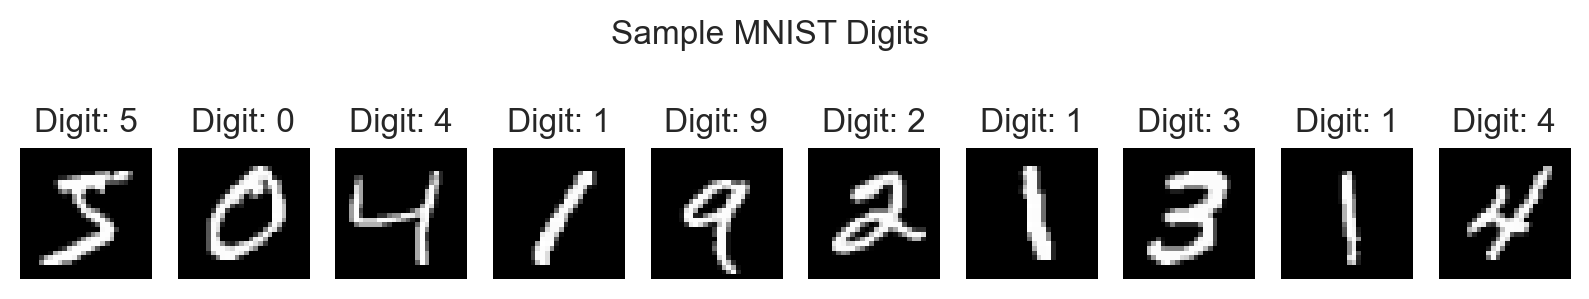

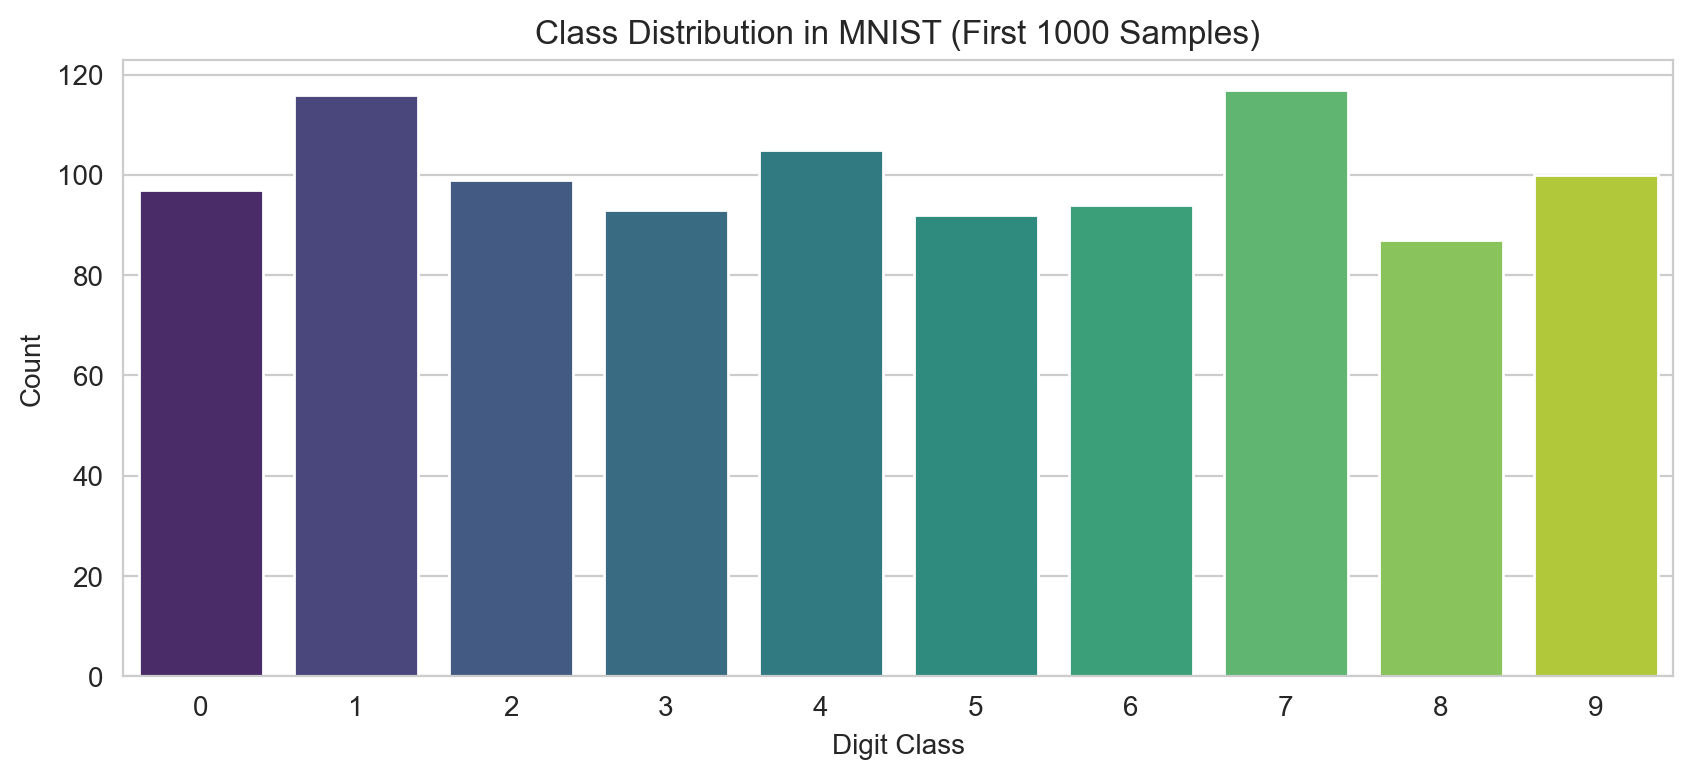

In [17]:
# Cell 3: Exploratory Data Analysis (EDA)
# Display sample images
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i, ax in enumerate(axes.flat):
    ax.imshow(raw_images[i], cmap='gray')
    ax.set_title(f'Digit: {raw_labels[i]}')
    ax.axis('off')
plt.suptitle('Sample MNIST Digits')
plt.show()

# Class distribution
plt.figure(figsize=(10, 4))
sns.countplot(x=raw_labels, palette='viridis')
plt.title('Class Distribution in MNIST (First 1000 Samples)')
plt.xlabel('Digit Class')
plt.ylabel('Count')
plt.show()

In [18]:
# Cell 4: Define CNN model in PyTorch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/5], Loss: 0.1638
Epoch [2/5], Loss: 0.0546
Epoch [3/5], Loss: 0.0393
Epoch [4/5], Loss: 0.0320
Epoch [5/5], Loss: 0.0242


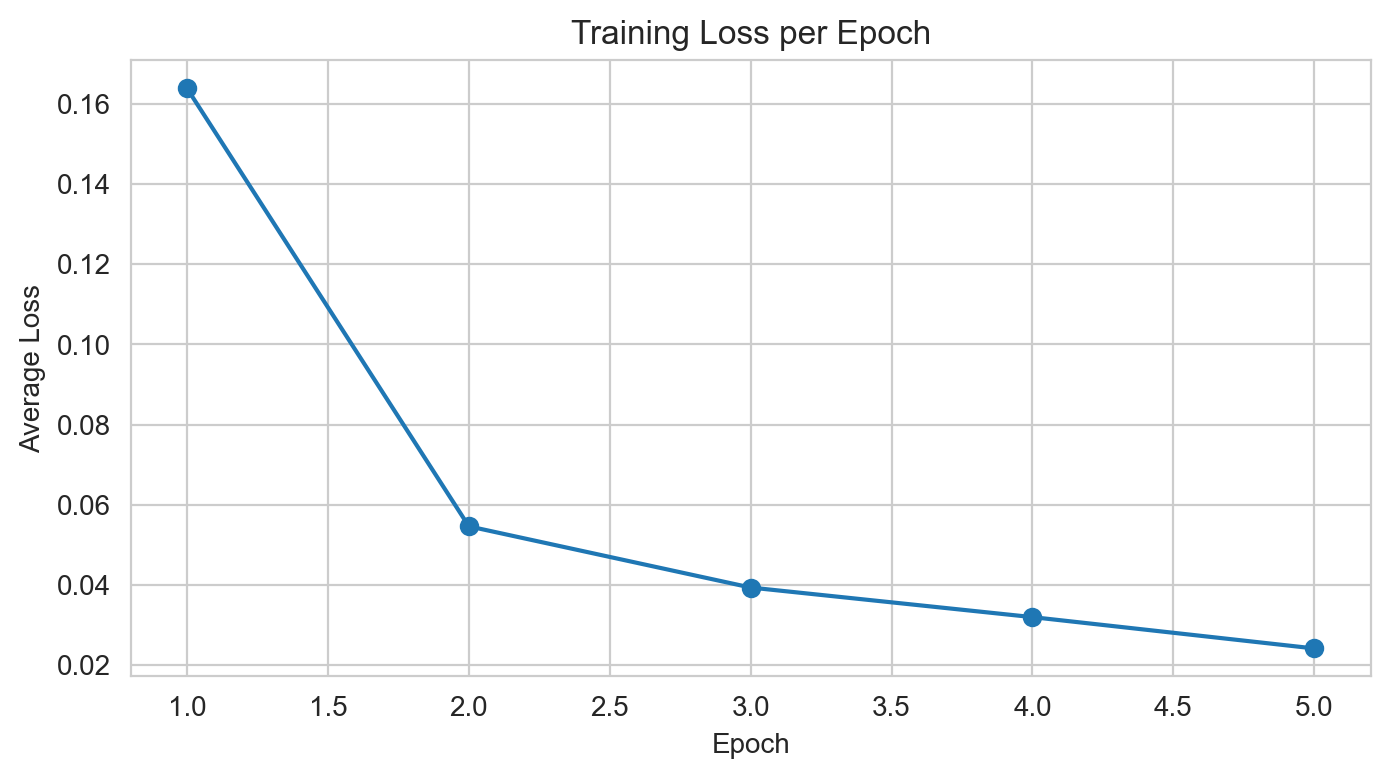

In [19]:
# Cell 5: Model training
num_epochs = 5
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0     0.9829    0.9980    0.9904       980
           1     0.9887    1.0000    0.9943      1135
           2     0.9951    0.9855    0.9903      1032
           3     0.9901    0.9941    0.9921      1010
           4     0.9919    0.9969    0.9944       982
           5     0.9932    0.9798    0.9865       892
           6     0.9958    0.9864    0.9911       958
           7     0.9836    0.9903    0.9869      1028
           8     0.9907    0.9867    0.9887       974
           9     0.9930    0.9841    0.9886      1009

    accuracy                         0.9904     10000
   macro avg     0.9905    0.9902    0.9903     10000
weighted avg     0.9904    0.9904    0.9904     10000



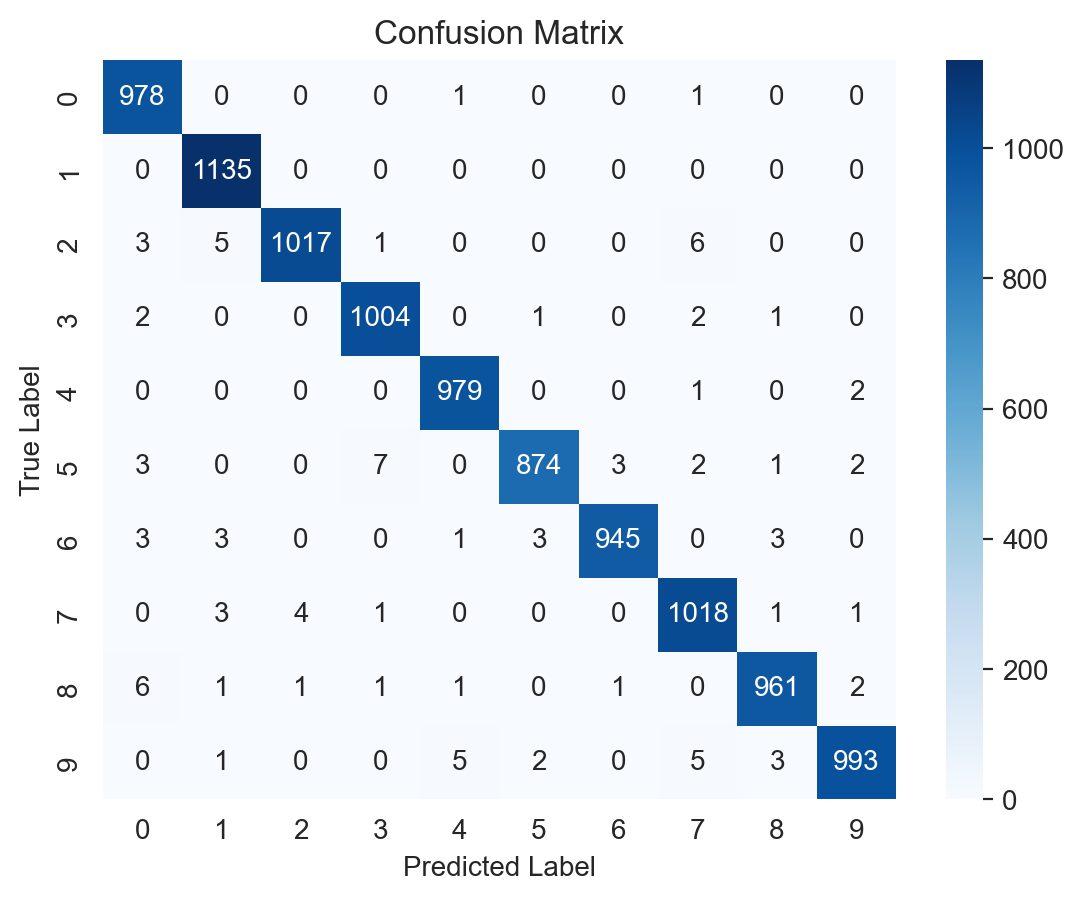

In [20]:
# Cell 6: Model evaluation and interpretation
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

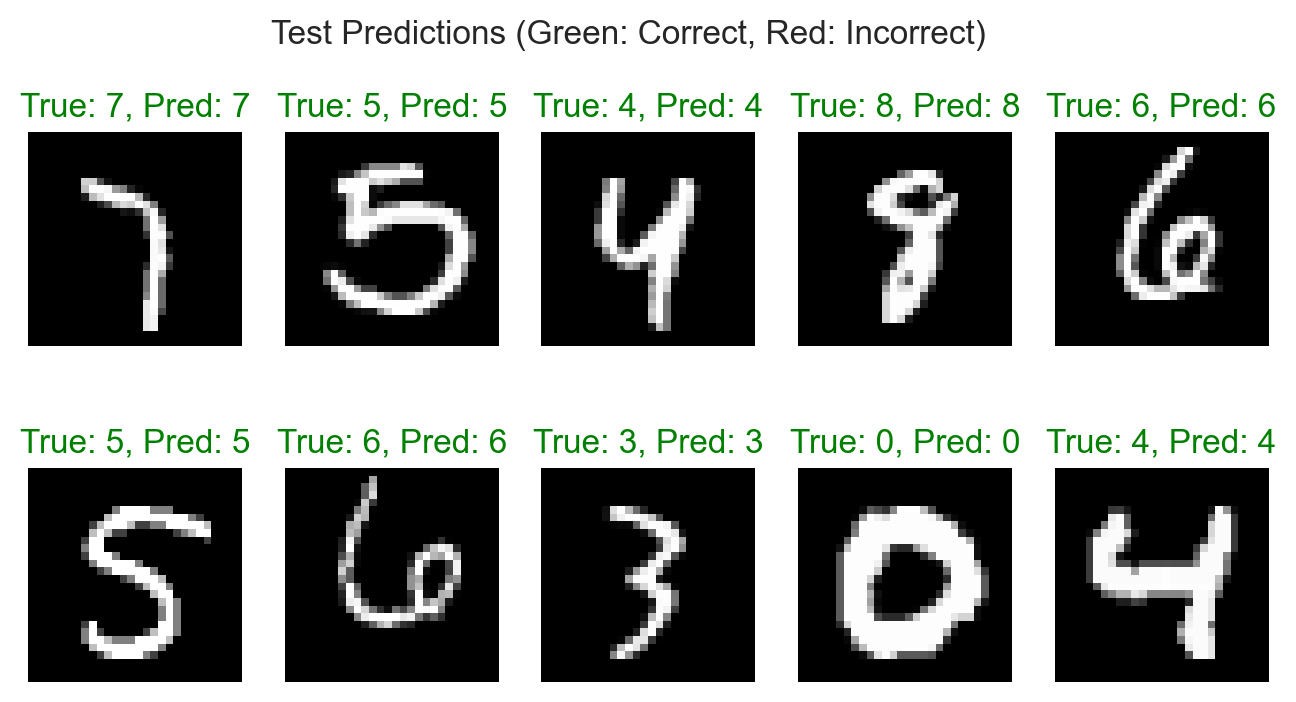

In [21]:
# Cell 7: Visualize some test predictions
# Get a batch of test data
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot 10 random predictions
indices = np.random.choice(len(images), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for idx, ax in zip(indices, axes.flat):
    img = images[idx].cpu().numpy().squeeze()
    true_label = labels[idx].item()
    pred_label = predicted[idx].item()
    color = 'green' if true_label == pred_label else 'red'
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
    ax.axis('off')
plt.suptitle('Test Predictions (Green: Correct, Red: Incorrect)')
plt.show()